<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [145]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [146]:
# Armar el dataset
import pandas as pd
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [147]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [148]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecto a cada clase
for i in range(0, 5):
    RatingCount = (df_reviews['Rating'] == i).sum()
    print(f"Number of rows with Rating {i}: {RatingCount}")

Number of rows with Rating 0: 821
Number of rows with Rating 1: 1549
Number of rows with Rating 2: 2823
Number of rows with Rating 3: 4908
Number of rows with Rating 4: 12540


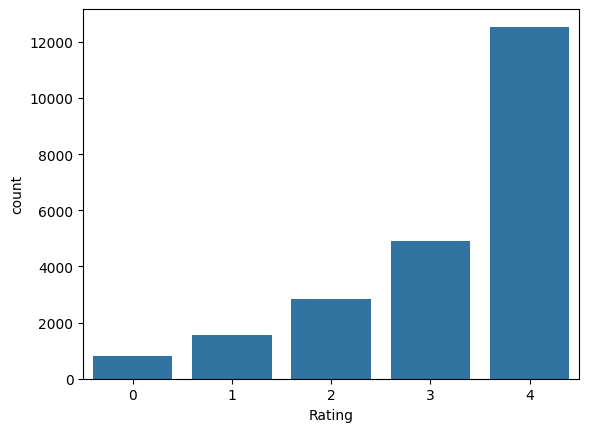

In [149]:
# Observar como está distribuido el dataset
sns.countplot(x='Rating', data=df_reviews)
plt.show()

In [150]:
# Find the minimum count of occurrences for any value in the "rating" column
min_count = df_reviews['Rating'].value_counts().min()

# Downsample the DataFrame to balance the number of rows for each rating
balanced_df = df_reviews.groupby('Rating').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

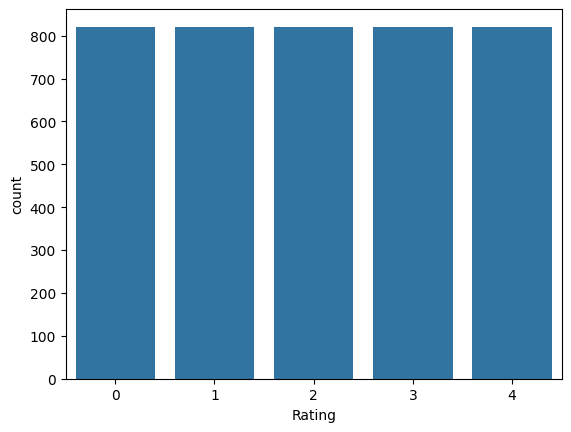

In [173]:
# Observar como está distribuido el dataset
sns.countplot(x='Rating', data=balanced_df)
df_reviews = balanced_df
plt.show()

In [174]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
ratings_array = df_reviews['Review Text'].values
print(ratings_array)

['I was really disappointed in the shirt. the blue embroidery is a lot darker than what is shown in the photo, and barely stands out against the black. the photo does not accurately depict this shirt. i will be returning.'
 "I was really excited about this sweater, but the fit was terrible. the sleeves were the right size, but the body of the sweater was a tent - absolutely no shape. they must have clipped the sweater on the model. for reference, i'm 5'4 and 120 pounds and ordered a size small."
 "This skirt has no closure along the slit. i can't begin to understand how it could be worn as shown in the photo-you would be completely exposed. it completely baffled me"
 ...
 "This top is even better than pictured. the colors are brighter, though still natural. this allows lots of possibilities with pairing bottoms to it. i ordered a large (my usual size) and would say it's pretty loose, but doesn't look ridiculous. it just hangs well and fits the way it should. the fabric is a little thin

In [175]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
print(df_reviews.shape[0])

4105


In [176]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = df_reviews['Review Text'].values
print(corpus)

['I was really disappointed in the shirt. the blue embroidery is a lot darker than what is shown in the photo, and barely stands out against the black. the photo does not accurately depict this shirt. i will be returning.'
 "I was really excited about this sweater, but the fit was terrible. the sleeves were the right size, but the body of the sweater was a tent - absolutely no shape. they must have clipped the sweater on the model. for reference, i'm 5'4 and 120 pounds and ordered a size small."
 "This skirt has no closure along the slit. i can't begin to understand how it could be worn as shown in the photo-you would be completely exposed. it completely baffled me"
 ...
 "This top is even better than pictured. the colors are brighter, though still natural. this allows lots of possibilities with pairing bottoms to it. i ordered a large (my usual size) and would say it's pretty loose, but doesn't look ridiculous. it just hangs well and fits the way it should. the fabric is a little thin

In [177]:
# Alumno: ¿Cuál es la longitud de ese corpus?
print(len(corpus))

4105


In [178]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
import numpy as np
train_len=4
tokenized_array = [text_to_word_sequence(document) for document in corpus]
print(tokenized_array[:5])

[['i', 'was', 'really', 'disappointed', 'in', 'the', 'shirt', 'the', 'blue', 'embroidery', 'is', 'a', 'lot', 'darker', 'than', 'what', 'is', 'shown', 'in', 'the', 'photo', 'and', 'barely', 'stands', 'out', 'against', 'the', 'black', 'the', 'photo', 'does', 'not', 'accurately', 'depict', 'this', 'shirt', 'i', 'will', 'be', 'returning'], ['i', 'was', 'really', 'excited', 'about', 'this', 'sweater', 'but', 'the', 'fit', 'was', 'terrible', 'the', 'sleeves', 'were', 'the', 'right', 'size', 'but', 'the', 'body', 'of', 'the', 'sweater', 'was', 'a', 'tent', 'absolutely', 'no', 'shape', 'they', 'must', 'have', 'clipped', 'the', 'sweater', 'on', 'the', 'model', 'for', 'reference', "i'm", "5'4", 'and', '120', 'pounds', 'and', 'ordered', 'a', 'size', 'small'], ['this', 'skirt', 'has', 'no', 'closure', 'along', 'the', 'slit', 'i', "can't", 'begin', 'to', 'understand', 'how', 'it', 'could', 'be', 'worn', 'as', 'shown', 'in', 'the', 'photo', 'you', 'would', 'be', 'completely', 'exposed', 'it', 'compl

In [179]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens = [word for sequence in tokenized_array for word in sequence]

# Now 'flattened_list' is a one-dimensional list containing all the words
print(tokens[:20])

['i', 'was', 'really', 'disappointed', 'in', 'the', 'shirt', 'the', 'blue', 'embroidery', 'is', 'a', 'lot', 'darker', 'than', 'what', 'is', 'shown', 'in', 'the']


In [180]:
# Alumno: ¿Cuántos tokens/palabras hay?
import numpy as np
print(len(tokens))

253571


In [181]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000) 
tok.fit_on_texts(tokens)

In [182]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
print(f'tamaño de vocabulario : {len(word_index)}')
index_word = tok.index_word
print(index_word)

tamaño de vocabulario : 7294
{1: 'the', 2: 'i', 3: 'and', 4: 'it', 5: 'a', 6: 'is', 7: 'this', 8: 'to', 9: 'in', 10: 'but', 11: 'was', 12: 'on', 13: 'of', 14: 'for', 15: 'not', 16: 'so', 17: 'dress', 18: 'my', 19: 'with', 20: 'that', 21: 'very', 22: 'like', 23: 'have', 24: 'size', 25: 'top', 26: 'me', 27: 'fit', 28: 'be', 29: 'are', 30: 'too', 31: 'as', 32: 'love', 33: 'just', 34: 'would', 35: "it's", 36: 'fabric', 37: 'wear', 38: "i'm", 39: 'at', 40: 'am', 41: 'you', 42: 'small', 43: 'they', 44: 'if', 45: 'or', 46: 'look', 47: 'ordered', 48: 'back', 49: 'up', 50: 'really', 51: 'great', 52: 'color', 53: 'one', 54: 'more', 55: 'had', 56: 'out', 57: 'an', 58: 'when', 59: 'material', 60: 'shirt', 61: 'all', 62: 'because', 63: 'than', 64: '\r', 65: 'looks', 66: 'large', 67: 'much', 68: 'cute', 69: 'these', 70: 'will', 71: 'even', 72: 'nice', 73: 'also', 74: 'well', 75: 'which', 76: 'little', 77: 'flattering', 78: 'sweater', 79: 'quality', 80: 'way', 81: 'beautiful', 82: 'them', 83: 'waist'

In [183]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(ratings_array)

In [184]:
# Alumno: Determinar cual es la oración más larga
seqs_lenght = [len(s) for s in sequences]
print(f'el máximo es {max(seqs_lenght)}')

el máximo es 111


In [185]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = max(seqs_lenght)

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [186]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(4105, 111)

In [187]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
from sklearn.preprocessing import OneHotEncoder
ratings = df_reviews['Rating'].values
print(ratings.shape)
numeric_vector_reshaped = ratings.reshape(-1, 1)
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(numeric_vector_reshaped)
print(y)

(4105,)
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


/Users/carlosmontiel/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [188]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [189]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 5
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 111 , out_shape 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [238]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# Entrenar un modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM,Embedding,Dropout,Bidirectional
from keras.regularizers import l2

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(Bidirectional(LSTM(units=256, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=128,kernel_regularizer=l2(0.01)))) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=out_shape, activation='sigmoid'))

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 111, 50)           100050    
                                                                 
 bidirectional_2 (Bidirecti  (None, 111, 512)          628736    
 onal)                                                           
                                                                 
 dropout_57 (Dropout)        (None, 111, 512)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               656384    
 onal)                                                           
                                                                 
 dense_56 (Dense)            (None, 256)               65792     
                                                                 
 dropout_58 (Dropout)        (None, 256)             

In [239]:
hist = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
83/83 [==============================] - 54s 561ms/step - loss: 3.6911 - accuracy: 0.1983 - val_loss: 0.6063 - val_accuracy: 0.1948
Epoch 2/10
83/83 [==============================] - 44s 530ms/step - loss: 0.5245 - accuracy: 0.1919 - val_loss: 0.5011 - val_accuracy: 0.2055
Epoch 3/10
83/83 [==============================] - 48s 577ms/step - loss: 0.5046 - accuracy: 0.2075 - val_loss: 0.5005 - val_accuracy: 0.1948
Epoch 4/10
83/83 [==============================] - 48s 577ms/step - loss: 0.5055 - accuracy: 0.1865 - val_loss: 0.5005 - val_accuracy: 0.2055
Epoch 5/10
83/83 [==============================] - 50s 606ms/step - loss: 0.5048 - accuracy: 0.1911 - val_loss: 0.5012 - val_accuracy: 0.2055
Epoch 6/10
83/83 [==============================] - 54s 647ms/step - loss: 0.5052 - accuracy: 0.1998 - val_loss: 0.5012 - val_accuracy: 0.2055
Epoch 7/10
83/83 [==============================] - 51s 617ms/step - loss: 0.5042 - accuracy: 0.2052 - val_loss: 0.5016 - val_accuracy: 0.2055

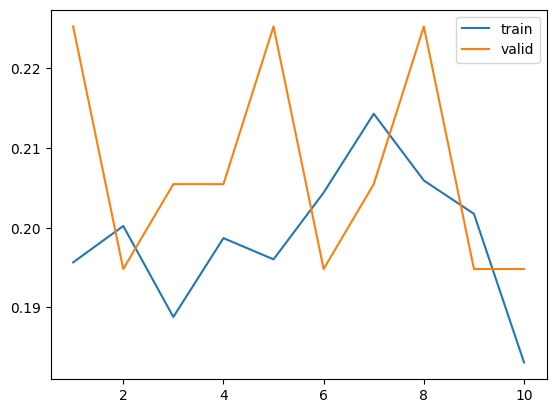

In [237]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [208]:
model.evaluate(X_test, y_test)

26/26 [==============================] - 1s 22ms/step - loss: 0.4510 - accuracy: 0.3752


[0.4510483145713806, 0.37515226006507874]

In [209]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
!curl -L -o 'fasttext.pkl' 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2746M  100 2746M    0     0  36.6M      0  0:01:14  0:01:14 --:--:-- 37.2M 0:01:19  0:00:15  0:01:04 37.0MM    0     0  36.5M      0  0:01:15  0:00:58  0:00:17 37.8M


In [240]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [241]:
model_fasttext = FasttextEmbeddings()

In [242]:
# Crear la Embedding matrix para la cantidad nb_words seleccionadas
# nos vamos a quedar sólo con los vectores de embeddings para las palabras
# que definimos como vocabulario

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index proviene del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))

# word_index está ordenado de mayor a menor frecuencia de palabras
# las primeras que entren en el ciclo for serán las más frecuentes
# Atención! El tokenizador de Keras no tiene soporte para stop words
# las primeras palabras probablemente sean stopwords, para eliminarlas
# hay que procesar el word_index o bien elegir otra librería para preprocesamiento
# ¡ver clase 2! ;)
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words que no estén en el índice de la matriz de embedding tendrán
        # como vector de embedding correspondiente todos ceros
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [243]:
# Definimos el modelo

model2 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model2.add(Embedding(input_dim=vocab_size, # definido en el Tokenizador
                     output_dim=embed_dim, # dimensión de los embeddings utilizados
                     input_length=in_shape, # máxima sentencia de entrada
                     weights=[embedding_matrix], # matrix de embeddings
                    trainable=False)) # marcar como layer no entrenable

model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=out_shape, activation='sigmoid'))

model2.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 111, 300)          600000    
                                                                 
 lstm_61 (LSTM)              (None, 111, 64)           93440     
                                                                 
 dropout_59 (Dropout)        (None, 111, 64)           0         
                                                                 
 lstm_62 (LSTM)              (None, 64)                33024     
                                                                 
 dense_58 (Dense)            (None, 128)               8320      
                                                                 
 dropout_60 (Dropout)        (None, 128)               0         
                                                                 
 dense_59 (Dense)            (None, 5)               

In [244]:
hist2 = model2.fit(X_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
83/83 [==============================] - 22s 128ms/step - loss: 0.5137 - accuracy: 0.2067 - val_loss: 0.5007 - val_accuracy: 0.1963
Epoch 2/5
83/83 [==============================] - 7s 82ms/step - loss: 0.5051 - accuracy: 0.1983 - val_loss: 0.5050 - val_accuracy: 0.1796
Epoch 3/5
83/83 [==============================] - 7s 81ms/step - loss: 0.5029 - accuracy: 0.2044 - val_loss: 0.5001 - val_accuracy: 0.2055
Epoch 4/5
83/83 [==============================] - 7s 81ms/step - loss: 0.5045 - accuracy: 0.1957 - val_loss: 0.4994 - val_accuracy: 0.2116
Epoch 5/5
83/83 [==============================] - 7s 81ms/step - loss: 0.5025 - accuracy: 0.2078 - val_loss: 0.5006 - val_accuracy: 0.2085


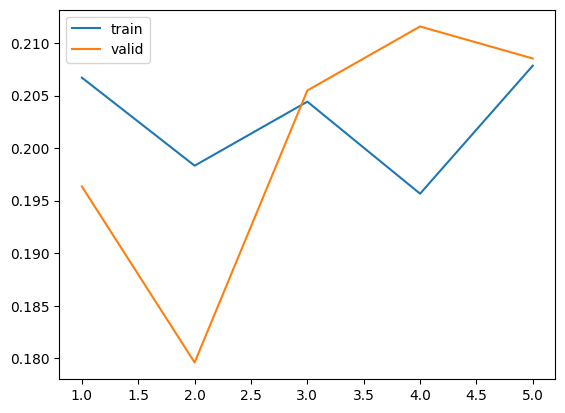

In [245]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

In [246]:
model2.evaluate(X_test, y_test)

26/26 [==============================] - 1s 31ms/step - loss: 0.4986 - accuracy: 0.2351


[0.49862489104270935, 0.23507916927337646]